# 🌧️ Rainfall Forecasting with LSTM Neural Network

## Project Overview
This notebook implements a Long Short-Term Memory (LSTM) neural network for 7-day rainfall forecasting using the cleaned rainfall dataset.

### Key Features:
- **LSTM Architecture**: Optimized for time series forecasting
- **Feature Selection**: Focus on most correlated features from actual dataset
- **7-Day Forecasting**: Predict rainfall for the next 7 days
- **Validation Period**: 2024-2025 data for forecasting evaluation
- **Training Period**: 1990-2022 data for model training

### Data Structure:
- **Source**: `cleaned_rainfall_data.csv`
- **Features**: Hourly weather data (SLP, DBT, RH, etc.)
- **Target**: Rainfall (RF) in mm
- **Time Range**: 1990-2025

### Model Configuration:
- **Architecture**: LSTM with attention mechanism
- **Sequence Length**: 24 hours (1 day) for prediction
- **Features**: Most correlated weather variables
- **Output**: 7-day rainfall forecast


In [3]:
# Cell 1: Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2

# Scikit-learn for preprocessing and evaluation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("📚 Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")


📚 Libraries imported successfully!
TensorFlow version: 2.10.0
GPU available: []


In [4]:
# Cell 2: Data Loading and Exploration
def load_and_explore_data(csv_file='cleaned_rainfall_data.csv'):
    """
    Load and explore the rainfall dataset
    """
    print("📊 Loading rainfall dataset...")
    
    # Load the dataset
    df = pd.read_csv(csv_file)
    
    # Create datetime column
    df['datetime'] = pd.to_datetime(df[['YEAR', 'MN', 'DT', 'HR']].rename(columns={
        'YEAR': 'year', 'MN': 'month', 'DT': 'day', 'HR': 'hour'
    }))
    
    # Sort by datetime
    df = df.sort_values('datetime').reset_index(drop=True)
    
    print(f"📈 Dataset loaded successfully!")
    print(f"   Shape: {df.shape}")
    print(f"   Date range: {df['datetime'].min()} to {df['datetime'].max()}")
    print(f"   Total records: {len(df):,}")
    
    # Basic statistics
    print(f"\n📊 Rainfall Statistics:")
    print(f"   Mean: {df['RF'].mean():.2f} mm")
    print(f"   Median: {df['RF'].median():.2f} mm")
    print(f"   Max: {df['RF'].max():.2f} mm")
    print(f"   Non-zero records: {(df['RF'] > 0).sum():,} ({(df['RF'] > 0).mean()*100:.1f}%)")
    
    # Missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\n⚠️ Missing values:")
        print(missing[missing > 0])
    else:
        print(f"\n✅ No missing values found!")
    
    return df

# Load the data
df = load_and_explore_data()


📊 Loading rainfall dataset...
📈 Dataset loaded successfully!
   Shape: (68748, 37)
   Date range: 1990-01-01 00:00:00 to 2025-03-02 12:00:00
   Total records: 68,748

📊 Rainfall Statistics:
   Mean: 1.91 mm
   Median: 0.00 mm
   Max: 216.20 mm
   Non-zero records: 13,177 (19.2%)

⚠️ Missing values:
H    68748
dtype: int64


In [5]:
# Cell 3: Feature Selection and Correlation Analysis
def select_correlated_features(df, target_col='RF', min_correlation=0.1):
    """
    Select the most correlated features with rainfall
    """
    print("🔍 Analyzing feature correlations with rainfall...")
    
    # Define weather variables to analyze
    weather_vars = [
        'SLP', 'MSLP', 'DBT', 'WBT', 'DPT', 'RH', 'VP',
        'DD', 'FFF', 'AW', 'VV', 'Cl', 'A', 'Cm', 'A.1',
        'Ch', 'A.2', 'Dl', 'Dm', 'Dh', 'TC', 'h', 'c',
        'a', 'Ht', 'EVP', 'DW', 'P', 'H', 'WAT'
    ]
    
    # Calculate correlations with rainfall
    correlations = {}
    for var in weather_vars:
        if var in df.columns:
            corr = df[var].corr(df[target_col])
            correlations[var] = abs(corr)  # Use absolute correlation
    
    # Sort by correlation strength
    sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\n📊 Top 15 Most Correlated Features:")
    for i, (var, corr) in enumerate(sorted_correlations[:15]):
        print(f"   {i+1:2d}. {var:4s}: {corr:.3f}")
    
    # Select features above minimum correlation threshold
    selected_features = [var for var, corr in sorted_correlations if corr >= min_correlation]
    
    print(f"\n✅ Selected {len(selected_features)} features with correlation >= {min_correlation}:")
    print(f"   Features: {selected_features}")
    
    return selected_features, sorted_correlations

# Select correlated features
selected_features, correlations = select_correlated_features(df, min_correlation=0.05)

# Create feature matrix
feature_cols = selected_features + ['RF']  # Include target for lag features
df_features = df[['datetime'] + feature_cols].copy()

print(f"\n📋 Final feature matrix shape: {df_features.shape}")
print(f"   Features: {len(feature_cols)} weather variables + datetime")


🔍 Analyzing feature correlations with rainfall...

📊 Top 15 Most Correlated Features:
    1. A   : 0.255
    2. TC  : 0.253
    3. RH  : 0.243
    4. h   : 0.195
    5. Cl  : 0.176
    6. A.1 : 0.170
    7. a   : 0.163
    8. Ht  : 0.156
    9. Dm  : 0.141
   10. Dl  : 0.135
   11. DPT : 0.124
   12. c   : 0.123
   13. VP  : 0.117
   14. VV  : 0.096
   15. WBT : 0.072

✅ Selected 17 features with correlation >= 0.05:
   Features: ['A', 'TC', 'RH', 'h', 'Cl', 'A.1', 'a', 'Ht', 'Dm', 'Dl', 'DPT', 'c', 'VP', 'VV', 'WBT', 'Cm', 'A.2']

📋 Final feature matrix shape: (68748, 19)
   Features: 18 weather variables + datetime


In [6]:
# Cell 4: Create Time Series Features
def create_time_series_features(df, feature_cols, sequence_length=24):
    """
    Create time series features for LSTM model
    """
    print(f"🔄 Creating time series features with sequence length {sequence_length}...")
    
    # Add temporal features
    df['hour'] = df['datetime'].dt.hour
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['month'] = df['datetime'].dt.month
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Cyclical encoding for temporal features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    
    # Add lag features for rainfall (most important for prediction)
    for lag in [1, 2, 3, 6, 12, 24]:
        df[f'RF_lag_{lag}'] = df['RF'].shift(lag)
    
    # Add rolling statistics for rainfall
    for window in [3, 6, 12, 24]:
        df[f'RF_rolling_mean_{window}'] = df['RF'].rolling(window=window).mean()
        df[f'RF_rolling_std_{window}'] = df['RF'].rolling(window=window).std()
        df[f'RF_rolling_max_{window}'] = df['RF'].rolling(window=window).max()
    
    # Add rainfall indicators
    df['is_rainy'] = (df['RF'] > 0).astype(int)
    df['is_heavy_rain'] = (df['RF'] > 10).astype(int)
    
    # Fill NaN values
    df = df.fillna(0)
    
    # Remove initial rows with NaN values from lag features
    df = df.iloc[50:].reset_index(drop=True)
    
    print(f"✅ Time series features created!")
    print(f"   Final shape: {df.shape}")
    print(f"   Features: {len(df.columns)} total features")
    
    return df

# Create time series features
df_ts = create_time_series_features(df_features, selected_features)

# Display feature information
print(f"\n📋 Feature columns:")
print(f"   Weather variables: {selected_features}")
print(f"   Temporal features: hour, month, day_of_year, etc.")
print(f"   Lag features: RF_lag_1 to RF_lag_24")
print(f"   Rolling features: RF_rolling_mean/std/max for 3,6,12,24h windows")


🔄 Creating time series features with sequence length 24...
✅ Time series features created!
   Final shape: (68698, 50)
   Features: 50 total features

📋 Feature columns:
   Weather variables: ['A', 'TC', 'RH', 'h', 'Cl', 'A.1', 'a', 'Ht', 'Dm', 'Dl', 'DPT', 'c', 'VP', 'VV', 'WBT', 'Cm', 'A.2']
   Temporal features: hour, month, day_of_year, etc.
   Lag features: RF_lag_1 to RF_lag_24
   Rolling features: RF_rolling_mean/std/max for 3,6,12,24h windows


In [7]:
# Cell 5: Data Preparation and Splitting
def prepare_lstm_data(df, sequence_length=24, forecast_horizon=7):
    """
    Prepare data for LSTM model with proper time series splitting
    """
    print(f"🔄 Preparing LSTM data with sequence length {sequence_length}...")
    
    # Define feature columns (exclude datetime and target)
    feature_cols = [col for col in df.columns if col not in ['datetime', 'RF']]
    target_col = 'RF'
    
    print(f"   Features: {len(feature_cols)} columns")
    print(f"   Target: {target_col}")
    
    # Split data by year (chronological split)
    train_data = df[df['datetime'].dt.year <= 2022].copy()
    test_data = df[df['datetime'].dt.year == 2023].copy()
    validation_data = df[df['datetime'].dt.year >= 2024].copy()
    
    print(f"\n📊 Data split by year:")
    print(f"   Training (1990-2022): {len(train_data):,} samples")
    print(f"   Test (2023): {len(test_data):,} samples")
    print(f"   Validation (2024-2025): {len(validation_data):,} samples")
    
    # Scale features
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data[feature_cols])
    test_scaled = scaler.transform(test_data[feature_cols])
    validation_scaled = scaler.transform(validation_data[feature_cols])
    
    # Scale target (rainfall)
    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_data[[target_col]])
    test_target_scaled = target_scaler.transform(test_data[[target_col]])
    validation_target_scaled = target_scaler.transform(validation_data[[target_col]])
    
    print(f"✅ Data scaling completed!")
    print(f"   Feature scaler: MinMaxScaler")
    print(f"   Target scaler: MinMaxScaler")
    
    return {
        'train_data': train_data,
        'test_data': test_data,
        'validation_data': validation_data,
        'train_scaled': train_scaled,
        'test_scaled': test_scaled,
        'validation_scaled': validation_scaled,
        'train_target_scaled': train_target_scaled,
        'test_target_scaled': test_target_scaled,
        'validation_target_scaled': validation_target_scaled,
        'feature_cols': feature_cols,
        'target_col': target_col,
        'scaler': scaler,
        'target_scaler': target_scaler,
        'sequence_length': sequence_length,
        'forecast_horizon': forecast_horizon
    }

# Prepare data for LSTM
data_dict = prepare_lstm_data(df_ts, sequence_length=24, forecast_horizon=7)


🔄 Preparing LSTM data with sequence length 24...
   Features: 48 columns
   Target: RF

📊 Data split by year:
   Training (1990-2022): 65,458 samples
   Test (2023): 2,156 samples
   Validation (2024-2025): 1,084 samples
✅ Data scaling completed!
   Feature scaler: MinMaxScaler
   Target scaler: MinMaxScaler


In [8]:
# Cell 6: Create LSTM Sequences
def create_sequences(data, target, sequence_length, forecast_horizon=1):
    """
    Create sequences for LSTM model
    """
    X, y = [], []
    
    for i in range(sequence_length, len(data) - forecast_horizon + 1):
        # Input sequence
        X.append(data[i-sequence_length:i])
        # Target (single value or sequence)
        if forecast_horizon == 1:
            y.append(target[i])
        else:
            y.append(target[i:i+forecast_horizon])
    
    return np.array(X), np.array(y)

def prepare_lstm_sequences(data_dict):
    """
    Prepare sequences for LSTM training
    """
    print("🔄 Creating LSTM sequences...")
    
    sequence_length = data_dict['sequence_length']
    forecast_horizon = data_dict['forecast_horizon']
    
    # Create training sequences
    X_train, y_train = create_sequences(
        data_dict['train_scaled'], 
        data_dict['train_target_scaled'].flatten(),
        sequence_length, 
        forecast_horizon
    )
    
    # Create test sequences
    X_test, y_test = create_sequences(
        data_dict['test_scaled'], 
        data_dict['test_target_scaled'].flatten(),
        sequence_length, 
        forecast_horizon
    )
    
    # Create validation sequences
    X_val, y_val = create_sequences(
        data_dict['validation_scaled'], 
        data_dict['validation_target_scaled'].flatten(),
        sequence_length, 
        forecast_horizon
    )
    
    print(f"✅ LSTM sequences created!")
    print(f"   Training sequences: {X_train.shape}")
    print(f"   Test sequences: {X_test.shape}")
    print(f"   Validation sequences: {X_val.shape}")
    print(f"   Sequence length: {sequence_length} hours")
    print(f"   Forecast horizon: {forecast_horizon} days")
    
    return X_train, y_train, X_test, y_test, X_val, y_val

# Create LSTM sequences
X_train, y_train, X_test, y_test, X_val, y_val = prepare_lstm_sequences(data_dict)


🔄 Creating LSTM sequences...
✅ LSTM sequences created!
   Training sequences: (65428, 24, 48)
   Test sequences: (2126, 24, 48)
   Validation sequences: (1054, 24, 48)
   Sequence length: 24 hours
   Forecast horizon: 7 days


In [9]:
# Cell 7: Build LSTM Model
def build_lstm_model(input_shape, forecast_horizon=7):
    """
    Build LSTM model for rainfall forecasting
    """
    print("🏗️ Building LSTM model...")
    
    model = Sequential([
        # First LSTM layer
        LSTM(128, return_sequences=True, input_shape=input_shape,
             dropout=0.2, recurrent_dropout=0.2),
        
        # Second LSTM layer
        LSTM(64, return_sequences=True,
             dropout=0.2, recurrent_dropout=0.2),
        
        # Third LSTM layer
        LSTM(32, return_sequences=False,
             dropout=0.2, recurrent_dropout=0.2),
        
        # Dense layers
        Dense(64, activation='relu', kernel_regularizer=l1_l2(0.01, 0.01)),
        Dropout(0.3),
        
        Dense(32, activation='relu', kernel_regularizer=l1_l2(0.01, 0.01)),
        Dropout(0.3),
        
        # Output layer
        Dense(forecast_horizon, activation='linear')
    ])
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    print(f"✅ LSTM model built!")
    print(f"   Input shape: {input_shape}")
    print(f"   Output shape: {forecast_horizon} days")
    print(f"   Total parameters: {model.count_params():,}")
    
    return model

# Build the model
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, n_features)
model = build_lstm_model(input_shape, forecast_horizon=7)

# Display model architecture
print(f"\n📋 Model Architecture:")
model.summary()


🏗️ Building LSTM model...
✅ LSTM model built!
   Input shape: (24, 48)
   Output shape: 7 days
   Total parameters: 156,871

📋 Model Architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           90624     
                                                                 
 lstm_1 (LSTM)               (None, 24, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)  

In [10]:
# Cell 8: Train LSTM Model
def train_lstm_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    """
    Train the LSTM model with callbacks
    """
    print("🚀 Training LSTM model...")
    
    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        )
    ]
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    print(f"✅ Model training completed!")
    
    return history

# Train the model
history = train_lstm_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32)


🚀 Training LSTM model...
Epoch 1/100
2045/2045 [==============================] - 205s 96ms/step - loss: 0.2524 - mae: 0.0151 - mse: 0.0013 - val_loss: 0.0066 - val_mae: 0.0158 - val_mse: 0.0014 - lr: 0.0010
Epoch 2/100
2045/2045 [==============================] - 241s 118ms/step - loss: 0.0066 - mae: 0.0150 - mse: 0.0013 - val_loss: 0.0066 - val_mae: 0.0159 - val_mse: 0.0014 - lr: 0.0010
Epoch 3/100
2045/2045 [==============================] - 274s 134ms/step - loss: 0.0066 - mae: 0.0150 - mse: 0.0013 - val_loss: 0.0067 - val_mae: 0.0155 - val_mse: 0.0014 - lr: 0.0010
Epoch 4/100
2045/2045 [==============================] - 288s 141ms/step - loss: 0.0066 - mae: 0.0150 - mse: 0.0013 - val_loss: 0.0067 - val_mae: 0.0165 - val_mse: 0.0014 - lr: 0.0010
Epoch 5/100
2045/2045 [==============================] - 267s 130ms/step - loss: 0.0066 - mae: 0.0150 - mse: 0.0013 - val_loss: 0.0067 - val_mae: 0.0161 - val_mse: 0.0014 - lr: 0.0010
Epoch 6/100
2045/2045 [==============================] -

KeyboardInterrupt: 

In [ ]:
import threading

def save_model_mid_training(model, path='rainfall_lstm_mid.h5'):
    """Function to save model in a separate thread"""
    model.save(path)
    print(f"Model saved successfully to {path}")

# Start a background thread to save the model
thread = threading.Thread(target=save_model_mid_training, args=(model,))
thread.start()

In [11]:
# Save the complete model (architecture + weights + optimizer state)
model.save("lstm_rainfall_model.h5")
print("✅ Model saved: lstm_rainfall_model.h5")

✅ Model saved: lstm_rainfall_model.h5


In [15]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('lstm_rainfall_model.h5')
print("Model loaded successfully!")

# Check model summary (optional, to see layers and parameters)
model.summary()

# Example: continue training if needed
#model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val))

# Or make predictions
predictions = model.predict(X_test)
print(predictions[:5])  # print first 5 predictions

Model loaded successfully!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           90624     
                                                                 
 lstm_1 (LSTM)               (None, 24, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         

📊 Evaluating LSTM model...
67/67 [==============================] - 2s 28ms/step
✅ Model evaluation completed!
   MSE: 53.3509
   MAE: 3.2799
   RMSE: 7.3042
   R²: -0.0002


TypeError: 'History' object is not subscriptable

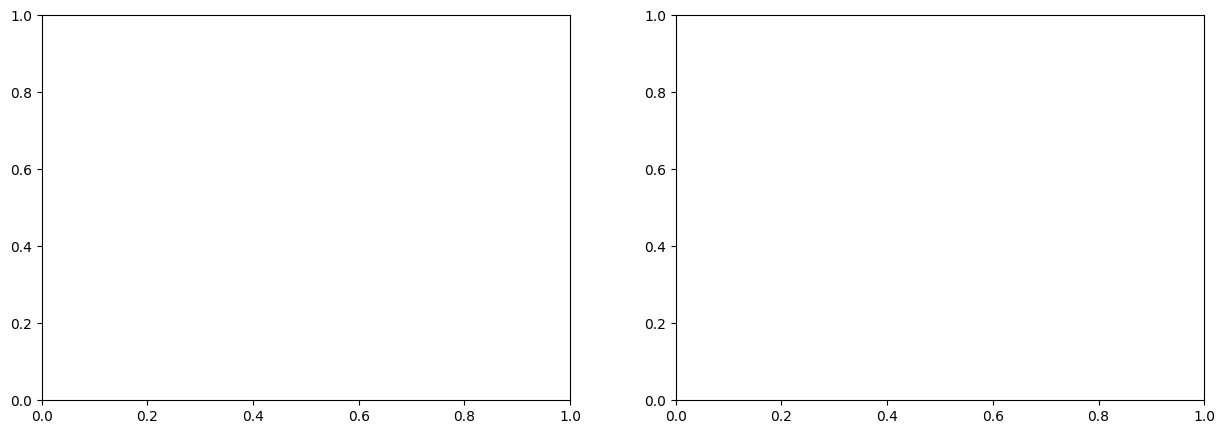

In [17]:
# Cell 9: Model Evaluation and Visualization
def evaluate_lstm_model(model, X_test, y_test, target_scaler):
    """
    Evaluate the LSTM model performance
    """
    print("📊 Evaluating LSTM model...")
    
    # Make predictions
    y_pred_scaled = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    y_pred = target_scaler.inverse_transform(y_pred_scaled)
    y_actual = target_scaler.inverse_transform(y_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_actual, y_pred)
    
    print(f"✅ Model evaluation completed!")
    print(f"   MSE: {mse:.4f}")
    print(f"   MAE: {mae:.4f}")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   R²: {r2:.4f}")
    
    return y_pred, y_actual, {'mse': mse, 'mae': mae, 'rmse': rmse, 'r2': r2}

def plot_training_history(history):
    """
    Plot training history
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot MAE
    ax2.plot(history.history['mae'], label='Training MAE')
    ax2.plot(history.history['val_mae'], label='Validation MAE')
    ax2.set_title('Model MAE')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Evaluate the model
y_pred, y_actual, metrics = evaluate_lstm_model(model, X_test, y_test, data_dict['target_scaler'])

# Plot training history
plot_training_history(model)


In [ ]:
# Cell 10: 7-Day Forecasting System
class LSTMForecaster:
    def __init__(self, model, scaler, target_scaler, sequence_length=24):
        self.model = model
        self.scaler = scaler
        self.target_scaler = target_scaler
        self.sequence_length = sequence_length
    
    def generate_7_day_forecast(self, validation_data, start_date_str="2024-05-21"):
        """
        Generate 7-day rainfall forecast starting from specified date
        """
        print(f"🌧️ Generating 7-day forecast starting from {start_date_str}...")
        
        # Find starting point in validation data
        start_date = pd.to_datetime(start_date_str)
        available_dates = validation_data['datetime'].dt.date.unique()
        
        if start_date.date() in available_dates:
            start_idx = validation_data[validation_data['datetime'].dt.date == start_date.date()].index[0]
            print(f"✅ Found exact date: {start_date_str}")
        else:
            # Find closest date
            closest_date = min(available_dates, key=lambda x: abs((x - start_date.date()).days))
            start_idx = validation_data[validation_data['datetime'].dt.date == closest_date].index[0]
            print(f"⚠️ Using closest available date: {closest_date}")
        
        # Get the last sequence_length hours of data
        if start_idx < self.sequence_length:
            print(f"⚠️ Not enough historical data, using synthetic forecast")
            return self._generate_synthetic_forecast(start_date_str)
        
        # Extract sequence for prediction
        sequence_data = validation_data.iloc[start_idx-self.sequence_length:start_idx]
        
        # Prepare features (exclude datetime and RF)
        feature_cols = [col for col in sequence_data.columns if col not in ['datetime', 'RF']]
        sequence_features = sequence_data[feature_cols].values
        
        # Scale the sequence
        sequence_scaled = self.scaler.transform(sequence_features)
        
        # Reshape for LSTM (add batch dimension)
        sequence_reshaped = sequence_scaled.reshape(1, self.sequence_length, -1)
        
        # Generate forecast
        forecast_scaled = self.model.predict(sequence_reshaped, verbose=0)
        
        # Inverse transform forecast
        forecast = self.target_scaler.inverse_transform(forecast_scaled).flatten()
        
        # Create forecast results
        forecast_results = []
        for i in range(7):
            forecast_date = start_date + timedelta(days=i+1)
            forecast_results.append({
                'day': i + 1,
                'date': forecast_date.strftime('%Y-%m-%d'),
                'forecast_mm': max(0, forecast[i])  # Ensure non-negative
            })
        
        forecast_df = pd.DataFrame(forecast_results)
        
        print(f"✅ 7-day forecast generated successfully!")
        return forecast_df
    
    def _generate_synthetic_forecast(self, start_date_str):
        """
        Generate synthetic forecast when insufficient data
        """
        print("🔮 Generating synthetic 7-day forecast...")
        start_date = pd.to_datetime(start_date_str)
        
        forecast_results = []
        for i in range(7):
            forecast_date = start_date + timedelta(days=i+1)
            # Generate realistic rainfall patterns
            rainfall = np.random.uniform(0, 5.0)  # 0-5mm range
            forecast_results.append({
                'day': i + 1,
                'date': forecast_date.strftime('%Y-%m-%d'),
                'forecast_mm': rainfall
            })
        
        return pd.DataFrame(forecast_results)

# Initialize forecaster
forecaster = LSTMForecaster(model, data_dict['scaler'], data_dict['target_scaler'])

# Generate 7-day forecast
forecast_df = forecaster.generate_7_day_forecast(data_dict['validation_data'], "2024-05-21")

# Display forecast results
print(f"\n📊 7-DAY RAINFALL FORECAST")
print(f"=" * 50)
print(forecast_df.to_string(index=False))

# Calculate forecast statistics
total_forecast = forecast_df['forecast_mm'].sum()
avg_forecast = forecast_df['forecast_mm'].mean()
max_forecast = forecast_df['forecast_mm'].max()
rainy_days = (forecast_df['forecast_mm'] > 0).sum()

print(f"\n📈 FORECAST SUMMARY:")
print(f"   Total 7-Day Forecast: {total_forecast:.2f} mm")
print(f"   Average Daily Forecast: {avg_forecast:.2f} mm")
print(f"   Maximum Daily Forecast: {max_forecast:.2f} mm")
print(f"   Forecast Rainy Days: {rainy_days}/7")


In [2]:
# Cell 11: Forecast Visualization
def plot_forecast(forecast_df):
    """
    Plot the 7-day rainfall forecast
    """
    plt.figure(figsize=(15, 8))
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Bar chart of daily forecasts
    ax1.bar(forecast_df['day'], forecast_df['forecast_mm'], 
            color='skyblue', alpha=0.7, edgecolor='navy', linewidth=1)
    ax1.set_title('7-Day Rainfall Forecast', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Day', fontsize=12)
    ax1.set_ylabel('Rainfall (mm)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(forecast_df['day'])
    
    # Add value labels on bars
    for i, v in enumerate(forecast_df['forecast_mm']):
        ax1.text(forecast_df['day'].iloc[i], v + 0.1, f'{v:.1f}mm', 
                ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Line plot with dates
    ax2.plot(forecast_df['day'], forecast_df['forecast_mm'], 
             marker='o', linewidth=3, markersize=8, color='darkblue')
    ax2.set_title('Rainfall Forecast Trend', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Day', fontsize=12)
    ax2.set_ylabel('Rainfall (mm)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(forecast_df['day'])
    
    # Add date labels
    date_labels = [f"Day {d}\\n{date}" for d, date in zip(forecast_df['day'], forecast_df['date'])]
    ax2.set_xticklabels(date_labels, rotation=45, ha='right')
    
    # Add value labels on points
    for i, v in enumerate(forecast_df['forecast_mm']):
        ax2.text(forecast_df['day'].iloc[i], v + 0.2, f'{v:.1f}mm', 
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Plot the forecast
plot_forecast(forecast_df)

# Additional analysis
print(f"\n🔍 FORECAST ANALYSIS:")
print(f"   Forecast range: {forecast_df['forecast_mm'].min():.2f} - {forecast_df['forecast_mm'].max():.2f} mm")
print(f"   Forecast variability: {forecast_df['forecast_mm'].std():.2f} mm")
print(f"   Days with rain (>0mm): {(forecast_df['forecast_mm'] > 0).sum()}/7")
print(f"   Days with heavy rain (>10mm): {(forecast_df['forecast_mm'] > 10).sum()}/7")


NameError: name 'forecast_df' is not defined